In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoConfig
from sentence_transformers import SentenceTransformer
from collections import Counter

c:\Users\RWP\Anaconda\envs\cogna_py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext watermark
%watermark -a "Rodrigo W Pisaia" --iversion --python

Author: Rodrigo W Pisaia

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.30.0

plotly               : 6.0.1
torch                : 2.6.0+cu124
pandas               : 2.2.3
sentence_transformers: 4.0.2
numpy                : 2.2.4
seaborn              : 0.13.2
re                   : 2.2.1
transformers         : 4.51.0
matplotlib           : 3.10.1



In [ ]:
def process_essay_with_conclusion(essay_array):
    cleaned_paragraphs = [str(p).strip() for p in essay_array if str(p).strip()]
    if not cleaned_paragraphs:
        return "", ""

    full_text = "\n".join(cleaned_paragraphs)
    conclusion = cleaned_paragraphs[-1] if cleaned_paragraphs else ""

    return full_text, conclusion

def add_processed_essay_columns(df: pd.DataFrame, essay_col: str = "essay"):
    processed = df[essay_col].apply(process_essay_with_conclusion)

    df["essay_full"] = processed.apply(lambda x: x[0])
    df["essay_conclusion"] = processed.apply(lambda x: x[1])

    return df

def extract_domain_features(df):
    # NOTE A Multi-aspect Analysis of Automatic Essay Scoring for Brazilian Portuguese papper - 2.2 Features
    # primeira pessoa (pronomes e verbos comuns)
    first_person_pronouns = [
        "eu",
        "meu",
        "minha",
        "me",
        "comigo",
        "nós",
        "nosso",
        "nossa",
    ]
    first_person_verbs = [
        "acho",
        "penso",
        "acredito",
        "creio",
        "considero",
        "entendo",
        "percebo",
        "sinto",
        "imagino",
        "pretendo",
        "desejo",
        "quero",
    ]

    df["first_person_total"] = df["essay_full"].apply(
        lambda x: sum(
            1
            for w in re.findall(r"\b\w+\b", x.lower())
            if w in first_person_pronouns + first_person_verbs
        )
    )

    # enclise (ex: "xxxx-lhe")
    df["enclisis_count"] = df["essay_full"].str.count(
        r"\b\w+-(lhe|la|lo|nos|vos|las|los)\b"
    )

    # pronomes demonstrativos
    demonstrative_pronouns = [
        "este",
        "esta",
        "isto",
        "esse",
        "essa",
        "isso",
        "aquele",
        "aquela",
        "aquilo",
    ]
    df["demonstrative_pronouns"] = df["essay_full"].apply(
        lambda x: sum(
            1 for w in re.findall(r"\b\w+\b", x.lower()) if w in demonstrative_pronouns
        )
    )

    # NOTE removido referente ao artigo o tokens_count pois o metodo de tokenizacao vai ser diferente do esperado do modelo utilizado
    # df["tokens_count"] 
    
    # Features normalizadas
    df["first_person_per_token"] = df["first_person_total"] / df[
        "tokens_count"
    ].replace(0, 1)
    df["enclisis_per_token"] = df["enclisis_count"] / df["tokens_count"].replace(0, 1)
    df["demonstrative_per_token"] = df["demonstrative_pronouns"] / df[
        "tokens_count"
    ].replace(0, 1)

    return df

In [5]:
df_train, df_val, df_test = (
    pd.read_parquet("../02_output/train.parquet" ),
    pd.read_parquet("../02_output/valid.parquet"),
    pd.read_parquet("../02_output/test.parquet"),
)

In [6]:
general_df = pd.concat([df_train, df_val, df_test], axis=0)
general_df.reset_index(drop=True, inplace=True)
general_df

,prompt_id,title,essay,score,prompt,comp1,comp2,comp3,comp4,comp5
0,60,Reforma da previdência,[É notório que a reforma da previdência no Bra...,440,"Reforma da Previdência Social, ou simplesmente...",120,80,80,120,40
1,51,ANALFABETISMO E SOCIEDADE,"[Pode -se afirmar que a presença dos Jesuítas,...",480,São chamados de analfabetos funcionais os indi...,120,120,80,80,80
2,73,Caminhos para superar os desafios encontrados ...,[Em 13 de maio de 1888 veio ao Brasil a lei da...,440,Título II (Dos Direitos e Garantias Fundamenta...,120,80,80,80,80
3,51,Analfabetismo funcional no Brasil tem solução.,[“Uma sociedade só progride quando um se mobil...,640,São chamados de analfabetos funcionais os indi...,120,160,120,120,120
4,59,None,"[Nas últimas décadas, o Brasil vem enfrentando...",560,A fome é a situação na qual a alimentação que ...,120,120,80,120,120
...,...,...,...,...,...,...,...,...,...,...
4565,46,A Privatização é Um Bom Caminho ?,[O saneamento básico no Brasil é muito precári...,600,Privatização é um processo da concessão ou ven...,120,120,80,160,120
4566,51,Analfabetismo no Brasil,[Antigamente muitos largaram os estudos e proc...,640,São chamados de analfabetos funcionais os indi...,160,120,120,120,120
4567,65,A juventude brasileira em risco,"[No cenário tenso da longa Idade Média, a soci...",800,"Entre 1996 e 2014, o número de jovens entre 12...",160,200,120,160,160
4568,58,None,[“Inteligência é a habilidade das espécies par...,800,"A Amazônia, que antes era um terreno florestal...",160,160,160,160,160


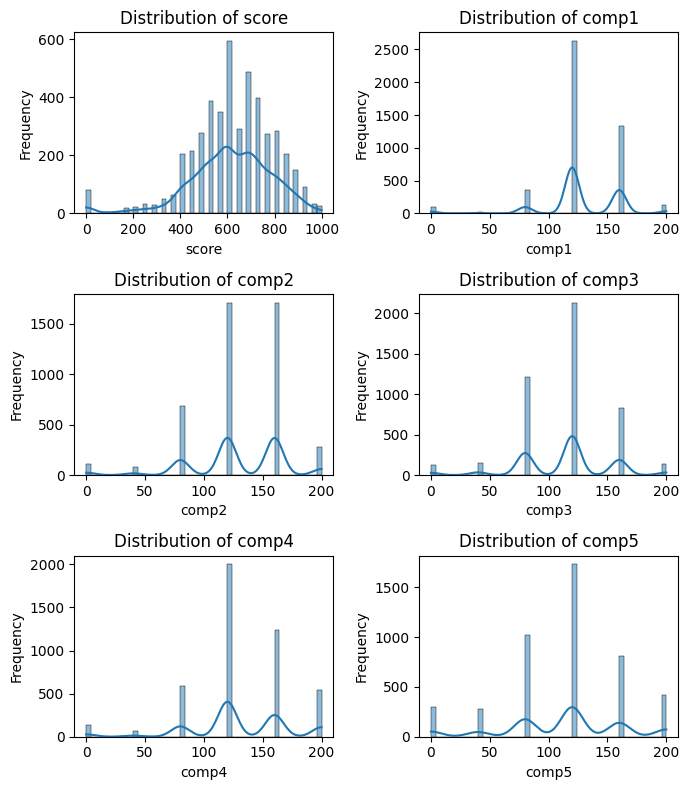

In [10]:
numerical_columns = general_df.select_dtypes(np.number).columns.tolist()
numerical_columns.remove("prompt_id")

fig, axs = plt.subplots(3, 2, figsize=(7, 8))
axs = axs.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(general_df[column], bins=50, kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {column}")
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

---
# Creating Features
---

In [62]:
general_df2 = add_processed_essay_columns(general_df, "essay")
general_df2.head(2)

,prompt_id,title,essay,score,prompt,comp1,comp2,comp3,comp4,comp5,essay_full,essay_conclusion
0,60,Reforma da previdência,[É notório que a reforma da previdência no Bra...,440,"Reforma da Previdência Social, ou simplesmente...",120,80,80,120,40,É notório que a reforma da previdência no Bras...,Colocando-se na balança os prós e os contras p...
1,51,ANALFABETISMO E SOCIEDADE,"[Pode -se afirmar que a presença dos Jesuítas,...",480,São chamados de analfabetos funcionais os indi...,120,120,80,80,80,"Pode -se afirmar que a presença dos Jesuítas, ...",Diante a suma o Ministério da Educação deve im...


In [67]:
extract_domain_features(general_df2)

,prompt_id,title,essay,score,prompt,comp1,comp2,comp3,comp4,comp5,essay_full,essay_conclusion,first_person_total,enclisis_count,demonstrative_pronouns,tokens_count,first_person_per_token,enclisis_per_token,demonstrative_per_token
0,60,Reforma da previdência,[É notório que a reforma da previdência no Bra...,440,"Reforma da Previdência Social, ou simplesmente...",120,80,80,120,40,É notório que a reforma da previdência no Bras...,Colocando-se na balança os prós e os contras p...,0,0,1,149,0.0,0.000000,0.006711
1,51,ANALFABETISMO E SOCIEDADE,"[Pode -se afirmar que a presença dos Jesuítas,...",480,São chamados de analfabetos funcionais os indi...,120,120,80,80,80,"Pode -se afirmar que a presença dos Jesuítas, ...",Diante a suma o Ministério da Educação deve im...,0,0,1,191,0.0,0.000000,0.005236
2,73,Caminhos para superar os desafios encontrados ...,[Em 13 de maio de 1888 veio ao Brasil a lei da...,440,Título II (Dos Direitos e Garantias Fundamenta...,120,80,80,80,80,Em 13 de maio de 1888 veio ao Brasil a lei da ...,Ainda bem que esse período acabou no Brasil nã...,0,0,4,167,0.0,0.000000,0.023952
3,51,Analfabetismo funcional no Brasil tem solução.,[“Uma sociedade só progride quando um se mobil...,640,São chamados de analfabetos funcionais os indi...,120,160,120,120,120,“Uma sociedade só progride quando um se mobili...,Em virtude dos fatos mencionados temos a consc...,0,0,3,295,0.0,0.000000,0.010169
4,59,None,"[Nas últimas décadas, o Brasil vem enfrentando...",560,A fome é a situação na qual a alimentação que ...,120,120,80,120,120,"Nas últimas décadas, o Brasil vem enfrentando ...","Portanto, é perceptível que as políticas públi...",0,0,1,202,0.0,0.000000,0.004950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,46,A Privatização é Um Bom Caminho ?,[O saneamento básico no Brasil é muito precári...,600,Privatização é um processo da concessão ou ven...,120,120,80,160,120,O saneamento básico no Brasil é muito precário...,"Torna-se evidente,portanto,que não basta ter p...",0,0,4,186,0.0,0.000000,0.021505
4566,51,Analfabetismo no Brasil,[Antigamente muitos largaram os estudos e proc...,640,São chamados de analfabetos funcionais os indi...,160,120,120,120,120,Antigamente muitos largaram os estudos e procu...,Concluo que para que a taxa de analfabetismo f...,0,2,0,250,0.0,0.008000,0.000000
4567,65,A juventude brasileira em risco,"[No cenário tenso da longa Idade Média, a soci...",800,"Entre 1996 e 2014, o número de jovens entre 12...",160,200,120,160,160,"No cenário tenso da longa Idade Média, a socie...","Em suma, estes fatores indevidos que envolvem ...",0,0,6,443,0.0,0.000000,0.013544
4568,58,None,[“Inteligência é a habilidade das espécies par...,800,"A Amazônia, que antes era um terreno florestal...",160,160,160,160,160,“Inteligência é a habilidade das espécies para...,"É importante, portanto, reafirmar que para pre...",0,1,4,406,0.0,0.002463,0.009852
